### colab 폰트 설정

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
!apt-get update -qq
!apt-get install fonts-nanum* -qq
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False # - 깨짐을 방지
fm._rebuild()

NanumBarunGothic


In [2]:
import pandas as pd
import numpy as np

import platform

import folium
import json

import warnings
warnings.filterwarnings('ignore')

# 우리나라 인구 소멸 위기 지역 분석

인구 소멸 위기 지역:
‘한국의 ‘지방소멸’에 관한 7가지 분석’ 보고서를 쓴 
이상호 한국고용정보원 부연구위원의 분석 방법을 이용. 

65세 이상 노인 인구와 20∼39세 여성 인구를 비교해 
젊은 여성 인구가 노인 인구의 절반에 미달할 경우, 
‘소멸 위험 지역’으로 분류하는 방식.

In [3]:
population = pd.read_excel('/content/drive/MyDrive/Encore/데이터분석/population_raw_data/data/05. population_raw_data.xlsx', header=1)

In [4]:
population.head(5)

,행정구역(동읍면)별(1),행정구역(동읍면)별(2),항목,계,20 - 24세,25 - 29세,30 - 34세,35 - 39세,65 - 69세,70 - 74세,75 - 79세,80 - 84세,85 - 89세,90 - 94세,95 - 99세,100+
0,전국,소계,총인구수 (명),51696216.0,3541061.0,3217367.0,3517868,4016272.0,2237345.0,1781229.0,1457890,909130.0,416164.0,141488.0,34844,17562.0
1,NaN,NaN,남자인구수 (명),25827594.0,1877127.0,1682988.0,1806754,2045265.0,1072395.0,806680.0,600607,319391.0,113221.0,32695.0,7658,4137.0
2,NaN,NaN,여자인구수 (명),25868622.0,1663934.0,1534379.0,1711114,1971007.0,1164950.0,974549.0,857283,589739.0,302943.0,108793.0,27186,13425.0
3,서울특별시,소계,총인구수 (명),9930616.0,690728.0,751973.0,803507,817467.0,448956.0,350580.0,251961,141649.0,66067.0,24153.0,7058,5475.0
4,NaN,NaN,남자인구수 (명),4876789.0,347534.0,372249.0,402358,410076.0,211568.0,163766.0,112076,54033.0,19595.0,6146.0,1900,1406.0


In [5]:
population.fillna(method="pad", inplace=True)
population.head(5)

,행정구역(동읍면)별(1),행정구역(동읍면)별(2),항목,계,20 - 24세,25 - 29세,30 - 34세,35 - 39세,65 - 69세,70 - 74세,75 - 79세,80 - 84세,85 - 89세,90 - 94세,95 - 99세,100+
0,전국,소계,총인구수 (명),51696216.0,3541061.0,3217367.0,3517868,4016272.0,2237345.0,1781229.0,1457890,909130.0,416164.0,141488.0,34844,17562.0
1,전국,소계,남자인구수 (명),25827594.0,1877127.0,1682988.0,1806754,2045265.0,1072395.0,806680.0,600607,319391.0,113221.0,32695.0,7658,4137.0
2,전국,소계,여자인구수 (명),25868622.0,1663934.0,1534379.0,1711114,1971007.0,1164950.0,974549.0,857283,589739.0,302943.0,108793.0,27186,13425.0
3,서울특별시,소계,총인구수 (명),9930616.0,690728.0,751973.0,803507,817467.0,448956.0,350580.0,251961,141649.0,66067.0,24153.0,7058,5475.0
4,서울특별시,소계,남자인구수 (명),4876789.0,347534.0,372249.0,402358,410076.0,211568.0,163766.0,112076,54033.0,19595.0,6146.0,1900,1406.0


In [6]:
population.columns

Index(['행정구역(동읍면)별(1)', '행정구역(동읍면)별(2)', '항목', '계', '20 - 24세', '25 - 29세',
       '30 - 34세', '35 - 39세', '65 - 69세', '70 - 74세', '75 - 79세', '80 - 84세',
       '85 - 89세', '90 - 94세', '95 - 99세', '100+'],
      dtype='object')

In [7]:
# 컬럼명이 길거나 특수기호가 포함된 컴렁명을 변경
population.rename(columns={"행정구역(동읍면)별(1)":"광역시도", "행정구역(동읍면)별(2)":"시도", "계":"인구수"}, inplace=True)

In [8]:
population.columns

Index(['광역시도', '시도', '항목', '인구수', '20 - 24세', '25 - 29세', '30 - 34세',
       '35 - 39세', '65 - 69세', '70 - 74세', '75 - 79세', '80 - 84세', '85 - 89세',
       '90 - 94세', '95 - 99세', '100+'],
      dtype='object')

In [9]:
population = population[(population['시도'] != "소계")]

In [10]:
population.rename(columns={"항목":"구분"}, inplace=True)

In [11]:
population.loc[population["구분"] ==  "총인구수 (명)", "구분" ] = "합계"
population.loc[population["구분"] ==  "남자인구수 (명)", "구분" ] = "남자"
population.loc[population["구분"] ==  "여자인구수 (명)", "구분" ] = "여자"

### 인구 소멸 위기 지역을 계산하고 데이터 정리

In [12]:
# 20~30대 여성 인구수 파악
population['20-39세'] = population['20 - 24세'] + population['25 - 29세'] + population['30 - 34세'] + population['35 - 39세']

In [13]:
# 65세 이상의 노인 인구수 파악
population['65세이상'] = population['65 - 69세'] + population['70 - 74세'] + \
                        population['75 - 79세'] + population['80 - 84세'] + \
                        population['85 - 89세'] + population['90 - 94세'] + \
                        population['95 - 99세'] + population['100+']

In [14]:
pop = pd.pivot_table(population,
                     index=["광역시도", "시도"],
                     columns=["구분"],
                     values=["인구수", "20-39세", "65세이상"])

### 인구 소멸 지역인지 파악

인구 소별 지역 계산을 위한 '소멸비율' 칼럼 추가

소멸 비율이 1보다 작으면 인구소멸지역으로 판단

In [15]:
pop["소멸비율"] = pop['20-39세', '여자'] / (pop["65세이상", "합계"] / 2)

In [16]:
# 소멸위기지역 컬럼추가 : 소멸위기지역 여부를 boolean 으로 지정
pop["소멸위기지역"]  = pop["소멸비율"] < 1.0
pop[pop["소멸위기지역"] == True].index.get_level_values(1)

Index(['고성군', '삼척시', '양양군', '영월군', '정선군', '평창군', '홍천군', '횡성군', '가평군', '양평군',
       '연천군', '거창군', '고성군', '남해군', '밀양시', '산청군', '의령군', '창녕군', '하동군', '함안군',
       '함양군', '합천군', '고령군', '군위군', '문경시', '봉화군', '상주시', '성주군', '영덕군', '영양군',
       '영주시', '영천시', '예천군', '울릉군', '울진군', '의성군', '청도군', '청송군', '동구', '영도구',
       '강화군', '옹진군', '강진군', '고흥군', '곡성군', '구례군', '담양군', '보성군', '신안군', '영광군',
       '영암군', '완도군', '장성군', '장흥군', '진도군', '함평군', '해남군', '화순군', '고창군', '김제시',
       '남원시', '무주군', '부안군', '순창군', '임실군', '장수군', '정읍시', '진안군', '공주시', '금산군',
       '논산시', '보령시', '부여군', '서천군', '예산군', '청양군', '태안군', '홍성군', '괴산군', '단양군',
       '보은군', '영동군', '옥천군'],
      dtype='object', name='시도')

In [17]:
# 여기까지 정리된 데이터프레임의 기존 index를 초기화하여 현재 광역시도, 시도 부분(index)의 데이터를 실제 데이터로 변경
pop.reset_index(inplace=True)

In [18]:
pop.head(3)

광역시도   시도   20-39세           ...       인구수                소멸비율 소멸위기지역
구분                 남자       여자  ...        여자        합계                 
0   강원도  강릉시  26286.0  23098.0  ...  107615.0  213846.0  1.226041  False
1   강원도  고성군   4494.0   2529.0  ...   14215.0   30114.0  0.707314   True
2   강원도  동해시  11511.0   9753.0  ...   46131.0   93297.0  1.289738  False

[3 rows x 13 columns]

In [19]:
# 기존 데이터프레임으로부터 컬럼명을 정리하여 리스트에 저장
tmp_coloumns = [pop.columns.get_level_values(0)[n] +  pop.columns.get_level_values(1)[n]  for n in range(0,len(pop.columns.get_level_values(0)))]
tmp_coloumns

['광역시도',
 '시도',
 '20-39세남자',
 '20-39세여자',
 '20-39세합계',
 '65세이상남자',
 '65세이상여자',
 '65세이상합계',
 '인구수남자',
 '인구수여자',
 '인구수합계',
 '소멸비율',
 '소멸위기지역']

In [20]:
pop.columns

MultiIndex([(  '광역시도',   ''),
            (    '시도',   ''),
            ('20-39세', '남자'),
            ('20-39세', '여자'),
            ('20-39세', '합계'),
            ( '65세이상', '남자'),
            ( '65세이상', '여자'),
            ( '65세이상', '합계'),
            (   '인구수', '남자'),
            (   '인구수', '여자'),
            (   '인구수', '합계'),
            (  '소멸비율',   ''),
            ('소멸위기지역',   '')],
           names=[None, '구분'])

In [21]:
pop.columns = tmp_coloumns
pop.columns

Index(['광역시도', '시도', '20-39세남자', '20-39세여자', '20-39세합계', '65세이상남자', '65세이상여자',
       '65세이상합계', '인구수남자', '인구수여자', '인구수합계', '소멸비율', '소멸위기지역'],
      dtype='object')

In [22]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   광역시도      264 non-null    object 
 1   시도        264 non-null    object 
 2   20-39세남자  264 non-null    float64
 3   20-39세여자  264 non-null    float64
 4   20-39세합계  264 non-null    float64
 5   65세이상남자   264 non-null    float64
 6   65세이상여자   264 non-null    float64
 7   65세이상합계   264 non-null    float64
 8   인구수남자     264 non-null    float64
 9   인구수여자     264 non-null    float64
 10  인구수합계     264 non-null    float64
 11  소멸비율      264 non-null    float64
 12  소멸위기지역    264 non-null    bool   
dtypes: bool(1), float64(10), object(2)
memory usage: 25.1+ KB


### 지도 시각화 작업

#### 지역별 고유 ID 생성

In [23]:
pop["시도"].unique()

array(['강릉시', '고성군', '동해시', '삼척시', '속초시', '양구군', '양양군', '영월군', '원주시',
       '인제군', '정선군', '철원군', '춘천시', '태백시', '평창군', '홍천군', '화천군', '횡성군',
       '가평군', '고양시', '과천시', '광명시', '광주시', '구리시', '군포시', '권선구', '기흥구',
       '김포시', '남양주시', '단원구', '덕양구', '동두천시', '동안구', '만안구', '부천시', '분당구',
       '상록구', '성남시', '소사구', '수원시', '수정구', '수지구', '시흥시', '안산시', '안성시',
       '안양시', '양주시', '양평군', '여주시', '연천군', '영통구', '오산시', '오정구', '용인시',
       '원미구', '의왕시', '의정부시', '이천시', '일산동구', '일산서구', '장안구', '중원구', '처인구',
       '파주시', '팔달구', '평택시', '포천시', '하남시', '화성시', '거제시', '거창군', '김해시',
       '남해군', '마산합포구', '마산회원구', '밀양시', '사천시', '산청군', '성산구', '양산시', '의령군',
       '의창구', '진주시', '진해구', '창녕군', '창원시', '통영시', '하동군', '함안군', '함양군',
       '합천군', '경산시', '경주시', '고령군', '구미시', '군위군', '김천시', '남구', '문경시',
       '봉화군', '북구', '상주시', '성주군', '안동시', '영덕군', '영양군', '영주시', '영천시',
       '예천군', '울릉군', '울진군', '의성군', '청도군', '청송군', '칠곡군', '포항시', '광산구',
       '동구', '서구', '달서구', '달성군', '수성구', '중구', '대덕구', '유성구', '강서구', '금정구',
       '기

In [24]:
si_name = [None] * len(pop)

In [25]:
# 샘플링 데이터
tmp_gu_dict = {'수원':['장안구', '권선구', '팔달구', '영통구'], 
               '성남':['수정구', '중원구', '분당구'], 
               '안양':['만안구', '동안구'], 
               '안산':['상록구', '단원구'], 
               '고양':['덕양구', '일산동구', '일산서구'], 
               '용인':['처인구', '기흥구', '수지구'], 
               '청주':['상당구', '서원구', '흥덕구', '청원구'], 
               '천안':['동남구', '서북구'], 
               '전주':['완산구', '덕진구'], 
               '포항':['남구', '북구'], 
               '창원':['의창구', '성산구', '진해구', '마산합포구', '마산회원구'], 
               '부천':['오정구', '원미구', '소사구']}

    만약, '광역시도' 컬럼의 데이터가 '광역시', '특별시', '자치시' 를 포함하지 않고,
        만약, '시도'컬럼의 데이터가 '고성'으로 끝나고  '광역시도' 컬럼의 데이터가 '강원도' 끝나면
            '고성('강원)'
        그렇지않고 만약,  '시도'컬럼의 데이터가 '고성'으로 끝나고  '광역시도' 컬럼의 데이터가 '경상남도' 끝나면
            '고성('경남)'
        그렇지않으면
            '고성'

    그헣지안으면

In [26]:
for n in pop.index:
    if pop['광역시도'][n][-3:] not in ['광역시', '특별시', '자치시']:
        if pop['시도'][n][:-1]=='고성' and pop['광역시도'][n]=='강원도':
            si_name[n] = '고성(강원)'
        elif pop['시도'][n][:-1]=='고성' and pop['광역시도'][n]=='경상남도':
            si_name[n] = '고성(경남)'
        else:
             si_name[n] = pop['시도'][n][:-1]
                
        for keys, values in tmp_gu_dict.items():
            if pop['시도'][n] in values:
                if len(pop['시도'][n])==2:
                    si_name[n] = keys + ' ' + pop['시도'][n]
                elif pop['시도'][n] in ['마산합포구','마산회원구']:
                    si_name[n] = keys + ' ' + pop['시도'][n][2:-1]
                else:
                    si_name[n] = keys + ' ' + pop['시도'][n][:-1]
        
    elif pop['광역시도'][n] == '세종특별자치시':
        si_name[n] = '세종'
        
    else:
        if len(pop['시도'][n])==2:
            si_name[n] = pop['광역시도'][n][:2] + ' ' + pop['시도'][n]
        else:
            si_name[n] = pop['광역시도'][n][:2] + ' ' + pop['시도'][n][:-1]

In [27]:
pop["ID"] = si_name

In [28]:
del pop['20-39세남자']
del pop['65세이상남자']
del pop['65세이상여자']

In [29]:
# 한국지도를 이용한 시각화
draw_korea_raw = pd.read_excel('/content/drive/MyDrive/Encore/데이터분석/population_raw_data/data/05. draw_korea_raw.xlsx')
# 각 행정구역의 화면상 좌표를 얻기위해 pivot_table의 정반대개념인 stack()를 사용하여 새로운 데이터프레임 생성
draw_korea_raw_stacked = pd.DataFrame(draw_korea_raw.stack())
# stack() 함수를 이용하여생성된 데이터프레임의 컬럼명 변경
# index를 초기화
draw_korea_raw_stacked.reset_index(inplace=True)

In [30]:
# 컬럼명 변경
draw_korea_raw_stacked.rename(columns={"level_0":"x", "level_1":"y", 0:"ID"}, inplace=True)
draw_korea_raw_stacked.head()

,x,y,ID
0,0,7,철원
1,0,8,화천
2,0,9,양구
3,0,10,고성(강원)
4,1,3,양주


In [31]:
draw_korea = draw_korea_raw_stacked

In [32]:
# ID 컬럼으로 지도를 표시할 때 시이름, 구이름으로 줄을 나누기 위해 데이터 분리를 위한 리스트 생성
BORDER_LINES = [
    [(5, 1), (5,2), (7,2), (7,3), (11,3), (11,0)], # 인천
    [(5,4), (5,5), (2,5), (2,7), (4,7), (4,9), (7,9), (7,7), (9,7), (9,5), (10,5), (10,4), (5,4)], # 서울
    [(1,7), (1,8), (3,8), (3,10), (10,10), (10,7), (12,7), (12,6), (11,6), (11,5), (12, 5), (12,4), (11,4), (11,3)], # 경기도
    [(8,10), (8,11), (6,11), (6,12)], # 강원도
    [(12,5), (13,5), (13,4), (14,4), (14,5), (15,5), (15,4), (16,4), (16,2)], # 충청북도
    [(16,4), (17,4), (17,5), (16,5), (16,6), (19,6), (19,5), (20,5), (20,4), (21,4), (21,3), (19,3), (19,1)], # 전라북도
    [(13,5), (13,6), (16,6)], # 대전시
    [(13,5), (14,5)], #세종시
    [(21,2), (21,3), (22,3), (22,4), (24,4), (24,2), (21,2)], #광주
    [(20,5), (21,5), (21,6), (23,6)], #전라남도
    [(10,8), (12,8), (12,9), (14,9), (14,8), (16,8), (16,6)], #충청북도
    [(14,9), (14,11), (14,12), (13,12), (13,13)], #경상북도
    [(15,8), (17,8), (17,10), (16,10), (16,11), (14,11)], #대구
    [(17,9), (18,9), (18,8), (19,8), (19,9), (20,9), (20,10), (21,10)], #부산
    [(16,11), (16,13)], #울산
    [(27,5), (27,6), (25,6)]
]

In [33]:
plt.figure(figsize=(8,11))

<Figure size 576x792 with 0 Axes>

<Figure size 576x792 with 0 Axes>

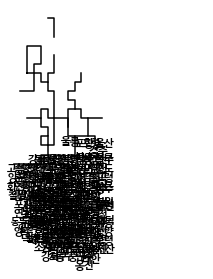

In [34]:
# 지역명 표시
for idx, row in draw_korea.iterrows():
    
    # 광역시는 구 이름이 겹치는 경우가 많아서 시단위 이름도 같이 표시한다. 
    # (중구, 서구)
    if len(row['ID'].split())==2:
        dispname = '{}\n{}'.format(row['ID'].split()[0], row['ID'].split()[1])
    elif row['ID'][:2]=='고성':
        dispname = '고성'
    else:
        dispname = row['ID']

    # 서대문구, 서귀포시 같이 이름이 3자 이상인 경우에 작은 글자로 표시한다.
    if len(dispname.splitlines()[-1]) >= 3:
        fontsize, linespacing = 9.5, 1.5
    else:
        fontsize, linespacing = 11, 1.2

    plt.annotate(dispname, (row['x']+0.5, row['y']+0.5), weight='bold',
                 fontsize=fontsize, ha='center', va='center', 
                 linespacing=linespacing)
for path in BORDER_LINES:
    ys, xs = zip(*path)
    plt.plot(xs, ys, c='black', lw=1.5)
    plt.gca().invert_yaxis()
plt.axis('off')
plt.tight_layout()
plt.show()

인구에 대한 분석결과인 pop 데이터프레임과 지도를 그리기 위한 draw_korea이 두 가지 데이터를 합할경우 사용할 ID 컬럼에 문제가 없는지 확인

In [35]:
set(draw_korea['ID'].unique()) - set(pop['ID'].unique())
set(pop['ID'].unique()) - set(draw_korea['ID'].unique())

{'고양', '부천', '성남', '수원', '안산', '안양', '용인', '전주', '창원', '천안', '청주', '포항'}

위 결과에 따르면 pop에 행정구를 가진 시들의 데이터가 더 있는 것이 확인되지만, 지도에는 표시할 수 없기때문에 삭제

In [36]:
tmp_list =  list(set(pop['ID'].unique()) - set(draw_korea['ID'].unique()))
for tmp in tmp_list:
    pop = pop.drop(pop[pop['ID'] == tmp].index)

In [37]:
# 삭제후, 데이터 재확인
set(pop['ID'].unique()) - set(draw_korea['ID'].unique())

set()

인구에 대한 분석결과인 pop 데이터프레임과 지도를 그리기 위한 draw_korea

In [38]:
# 두 데이터프레임의 병합 : merge()
# 병합 기준 : ID 칼럼
pop = pd.merge(pop, draw_korea, on=['ID'], how='left')
mapdata = pop.pivot_table(index='y', columns='x', values='인구수합계')

In [39]:
masked_mapdata = np.ma.masked_where(np.isnan(mapdata), mapdata)

In [40]:
# 위의 내용과 colormap을 생성하는 사용자 함수선언
def drawKorea(targetData, blockedMap, cmapname):

    whitelabelmin = (max(blockedMap[targetData]) - min(blockedMap[targetData]))*0.25 +  min(blockedMap[targetData])

    datalabel = targetData

    vmin = min(blockedMap[targetData])
    vmax = max(blockedMap[targetData])

    mapdata = blockedMap.pivot_table(index='y', columns='x', values=targetData)
    masked_mapdata = np.ma.masked_where(np.isnan(mapdata), mapdata)
    
    plt.figure(figsize=(9, 11))
    plt.pcolor(masked_mapdata, vmin=vmin, vmax=vmax, cmap=cmapname, 
               edgecolor='#aaaaaa', linewidth=0.5)

    # 지역 이름 표시
    for idx, row in blockedMap.iterrows():
        # 광역시는 구 이름이 겹치는 경우가 많아서 시단위 이름도 같이 표시한다. 
        #(중구, 서구)
        if len(row['ID'].split())==2:
            dispname = '{}\n{}'.format(row['ID'].split()[0], row['ID'].split()[1])
        elif row['ID'][:2]=='고성':
            dispname = '고성'
        else:
            dispname = row['ID']

        # 서대문구, 서귀포시 같이 이름이 3자 이상인 경우에 작은 글자로 표시한다.
        if len(dispname.splitlines()[-1]) >= 3:
            fontsize, linespacing = 10.0, 1.1
        else:
            fontsize, linespacing = 11, 1.

        annocolor = 'white' if row[targetData] > whitelabelmin else 'black'
        plt.annotate(dispname, (row['x']+0.5, row['y']+0.5), weight='bold',
                     fontsize=fontsize, ha='center', va='center', color=annocolor,
                     linespacing=linespacing)

    # 시도 경계 그린다.
    for path in BORDER_LINES:
        xs, ys = zip(*path)
        plt.plot(xs, ys, c='black', lw=2)

    plt.gca().invert_yaxis()

    plt.axis('off')

    cb = plt.colorbar(shrink=.1, aspect=10)
    cb.set_label(datalabel)

    plt.tight_layout()
    plt.show()

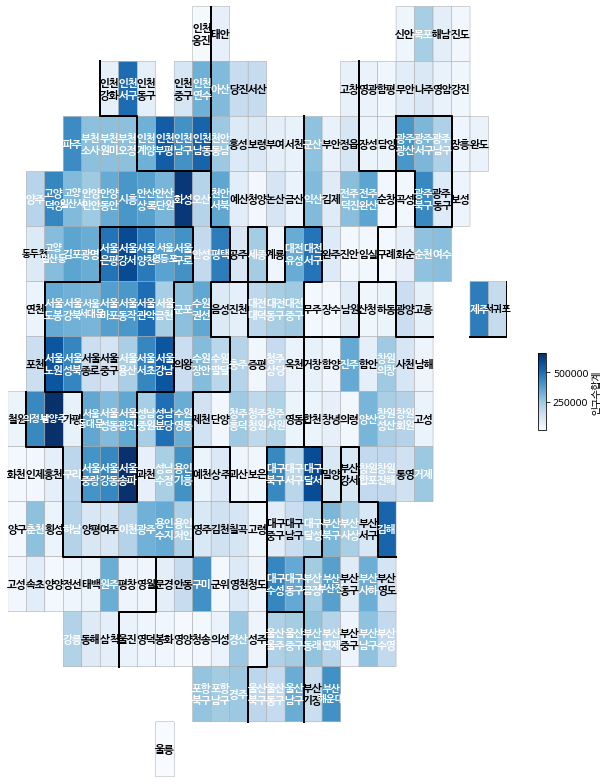

In [41]:
# 선언된 사용자 함수를 이용하여 인구 현황 및 인구 소멸 지역 확인
# 인구현황
drawKorea('인구수합계', pop, 'Blues')

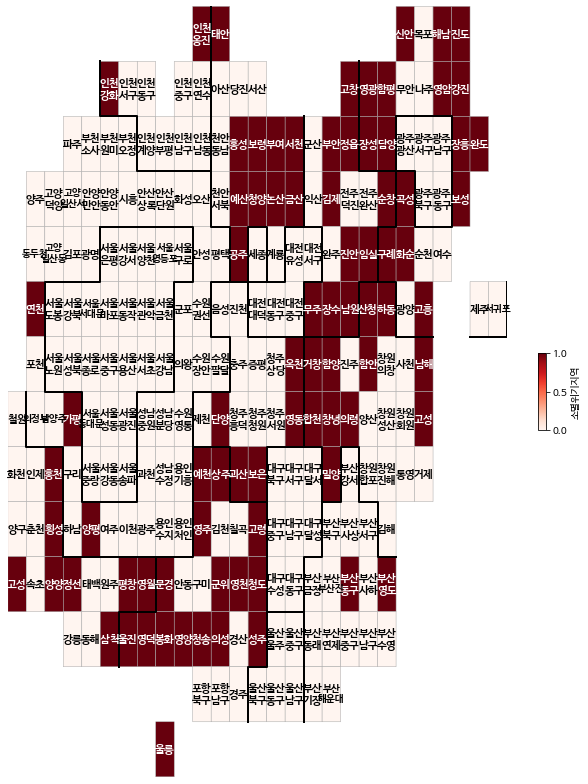

In [42]:
# 인구 소멸 위기지역
pop['소멸위기지역'] = [ 1 if con else 0  for con in pop['소멸위기지역']]
drawKorea('소멸위기지역', pop, 'Reds')

# 인구현황에서 여성 인구 비율 확인

In [43]:
# 인구현황에서 여성 인구 비율 확인 함수
def drawKorea(targetData, blockedMap, cmapname):

    whitelabelmin = 20.

    datalabel = targetData

    tmp_max = max([ np.abs(min(blockedMap[targetData])), 
                                  np.abs(max(blockedMap[targetData]))])
    vmin, vmax = -tmp_max, tmp_max

    mapdata = blockedMap.pivot_table(index='y', columns='x', values=targetData)
    masked_mapdata = np.ma.masked_where(np.isnan(mapdata), mapdata)
    
    plt.figure(figsize=(9, 11))
    plt.pcolor(masked_mapdata, vmin=vmin, vmax=vmax, cmap=cmapname, 
               edgecolor='#aaaaaa', linewidth=0.5)

    # 지역 이름 표시
    for idx, row in blockedMap.iterrows():
        # 광역시는 구 이름이 겹치는 경우가 많아서 시단위 이름도 같이 표시한다. 
        #(중구, 서구)
        if len(row['ID'].split())==2:
            dispname = '{}\n{}'.format(row['ID'].split()[0], row['ID'].split()[1])
        elif row['ID'][:2]=='고성':
            dispname = '고성'
        else:
            dispname = row['ID']

        # 서대문구, 서귀포시 같이 이름이 3자 이상인 경우에 작은 글자로 표시한다.
        if len(dispname.splitlines()[-1]) >= 3:
            fontsize, linespacing = 10.0, 1.1
        else:
            fontsize, linespacing = 11, 1.

        annocolor = 'white' if np.abs(row[targetData]) > whitelabelmin else 'black'
        plt.annotate(dispname, (row['x']+0.5, row['y']+0.5), weight='bold',
                     fontsize=fontsize, ha='center', va='center', color=annocolor,
                     linespacing=linespacing)

    # 시도 경계 그린다.
    for path in BORDER_LINES:
        xs, ys = zip(*path)
        plt.plot(xs, ys, c='black', lw=2)

    plt.gca().invert_yaxis()

    plt.axis('off')

    cb = plt.colorbar(shrink=.1, aspect=10)
    cb.set_label(datalabel)

    plt.tight_layout()
    plt.show()


In [44]:
# 여성비율
pop['여성비'] = (pop['인구수여자'] / pop['인구수합계'] - 0.5) * 100

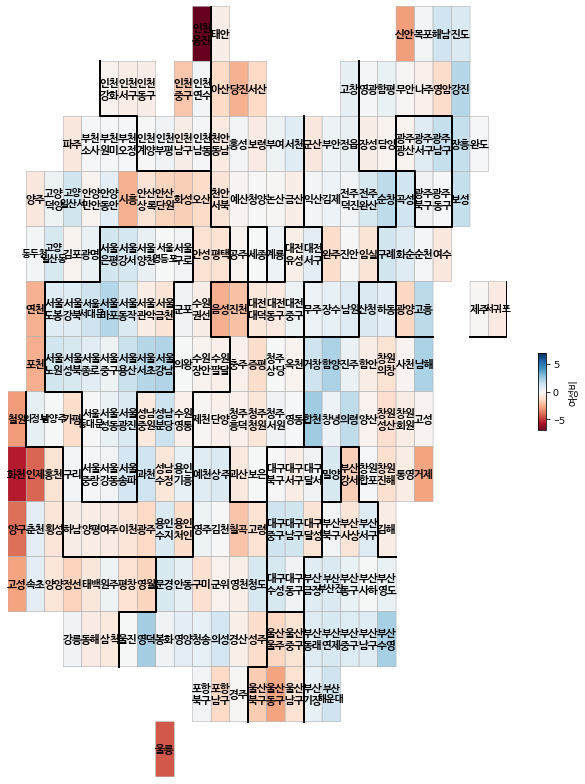

In [45]:
# 여성비율 확인
drawKorea('여성비', pop, 'RdBu')

In [46]:
# 20-30 대 여성비
pop['2030여성비'] = (pop['20-39세여자'] / pop['20-39세합계'] - 0.5) * 100

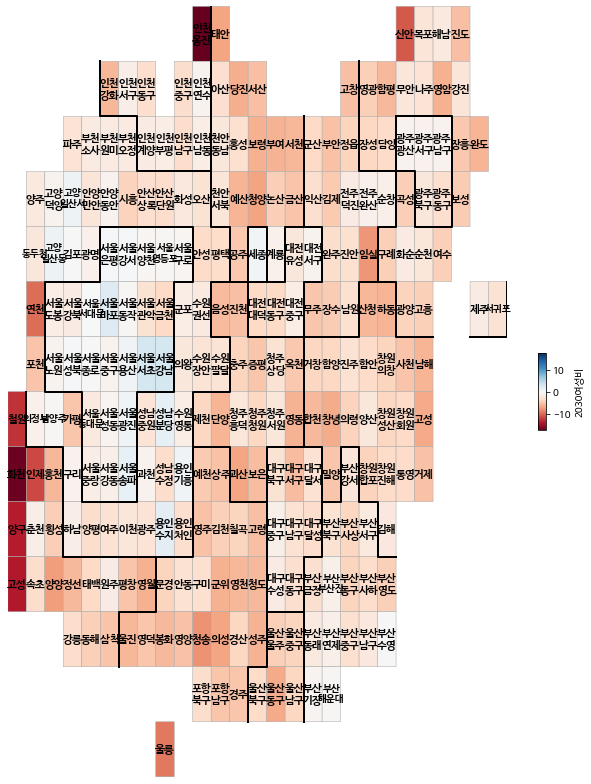

In [47]:
# 20-30 대 여성비율 확인
drawKorea('2030여성비', pop, 'RdBu')

In [48]:
# folium을 이용한 최종 시각화 : 05. skorea_municipalities_geo_simple.json
# pop 데이터프레임의 index를 'ID' 컬럼으로 설정
pop_folium = pop.set_index('ID')

In [49]:
# json 데이터 로드
geo_path = '/content/drive/MyDrive/Encore/데이터분석/population_raw_data/data/05. skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

In [50]:
# 인구수 합계
map = folium.Map(location=[36.2002, 127.054], 
                 zoom_start=7)

map.choropleth(geo_data=geo_str, 
               data=pop_folium['인구수합계'], 
               columns=[pop_folium.index, pop_folium['인구수합계']],
               fill_color='YlGnBu',
               key_on='feature.id')
# map.save('인구수합계.html')
map

In [71]:
# 인구 소멸 위기 지역
map = folium.Map(location=[36.2002, 127.054], 
                 zoom_start=7)

map.choropleth(geo_data=geo_str, 
               data=pop_folium['소멸위기지역'], 
               columns=[pop_folium.index, pop_folium['소멸위기지역']],
               fill_color='PuRd',
               key_on='feature.id')
# map.save('소멸위기지역.html')
map

In [72]:
import webbrowser
webbrowser.open_new('인구수합계.html')
webbrowser.open_new('소멸위기지역.html')

False